In [1]:
%matplotlib inline 

from collections import defaultdict, namedtuple
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from scipy.stats import poisson

In [2]:
RENTAL_LAMBDA1 = 3
RENTAL_LAMBDA2 = 4

RETURN_LAMBDA1 = 3
RETURN_LAMBDA2 = 2

COST_OF_MOVING = 2
COST_OF_RENTAL = 10

DISCOUNT_RATE = 0.9

MAX_N_CARS = 20
MAX_N_MOVING_CARS = 5

POISSON_CUTOFF = 15

In [3]:
ACTIONS = tuple(range(-MAX_N_MOVING_CARS, MAX_N_MOVING_CARS + 1))
State = namedtuple("State",  "loc1 loc2")
STATES = tuple([State(i, j) for i in range(MAX_N_CARS + 1) for j in range(MAX_N_CARS + 1)])

In [4]:
def get_expected_return_table():
    expected_return_table = {}
    
    for current_state in STATES:
        for action in ACTIONS:
            if action >= 0: # move loc1 -> loc2
                possible_movement = min(action, current_state.loc1)
                state_loc1 = current_state.loc1 - possible_movement
                state_loc2 = current_state.loc2 + possible_movement
                state_loc2 = min(state_loc2, MAX_N_CARS)
            else: # move loc2 -> loc1 
                possible_movement = min(abs(action), current_state.loc2)
                state_loc2 = current_state.loc2 - possible_movement 
                state_loc1 = current_state.loc1 + possible_movement
                state_loc1 = min(state_loc1, MAX_N_CARS)

            expected_revenue = -abs(action) * COST_OF_MOVING

            for n_rentals1 in range(POISSON_CUTOFF):
                for n_rentals2 in range(POISSON_CUTOFF):
                    p = poisson.pmf(n_rentals1, mu=RENTAL_LAMBDA1) * poisson.pmf(n_rentals2, mu=RENTAL_LAMBDA2)
                    possible_rental1 = min(state_loc1, n_rentals1)
                    possible_rental2 = min(state_loc2, n_rentals2)
                    possible_rentals = possible_rental1 + possible_rental2

                    expected_revenue += p * possible_rentals * COST_OF_RENTAL
            
            expected_return_table[(current_state, action)] = expected_revenue
            
    return expected_return_table

In [5]:
%%time 
expected_return_table = get_expected_return_table()

CPU times: user 1min 56s, sys: 47.2 ms, total: 1min 56s
Wall time: 1min 56s


In [6]:
len(expected_return_table) # 441 * 11 

4851

In [7]:
def get_transition_probability_table(first_location: bool):
    transition_probability_table = defaultdict(dict)
    
    for current_state in STATES:
        for action in ACTIONS:
            if action >= 0: # move loc1 -> loc2
                possible_movement = min(action, current_state.loc1)
                state_loc1 = current_state.loc1 - possible_movement
                state_loc2 = current_state.loc2 + possible_movement
                state_loc2 = min(state_loc2, MAX_N_CARS)
            else: # move loc2 -> loc1 
                possible_movement = min(abs(action), current_state.loc2)
                state_loc2 = current_state.loc2 - possible_movement 
                state_loc1 = current_state.loc1 + possible_movement
                state_loc1 = min(state_loc1, MAX_N_CARS)

            if first_location:
                current_state_morning = state_loc1
            else:
                current_state_morning = state_loc2

            for n_rentals in range(POISSON_CUTOFF):
                for n_returns in range(POISSON_CUTOFF):
                    if first_location:
                        p = poisson.pmf(n_rentals, mu=RENTAL_LAMBDA1) * poisson.pmf(n_returns, mu=RETURN_LAMBDA1)
                    else:
                        p = poisson.pmf(n_rentals, mu=RENTAL_LAMBDA2) * poisson.pmf(n_returns, mu=RETURN_LAMBDA2)

                    current_state_morning = max(0, current_state_morning - n_rentals)
                    next_loc = min(MAX_N_CARS, current_state_morning + n_returns)

                    old_p = transition_probability_table[(current_state, action)].get(next_loc, 0)
                    transition_probability_table[(current_state, action)][next_loc] = old_p + p
                            
    return dict(transition_probability_table)

In [8]:
%%time
transition_prob_table1 = get_transition_probability_table(True)

CPU times: user 1min 51s, sys: 24 ms, total: 1min 52s
Wall time: 1min 52s


In [9]:
%%time 
transition_prob_table2 = get_transition_probability_table(False)

CPU times: user 1min 49s, sys: 17 µs, total: 1min 49s
Wall time: 1min 50s


In [10]:
def value_iteration(
    value_function: np.ndarray, 
    expected_return_table: Dict[Tuple[State, int], float] = expected_return_table,
    transition_prob_table1: Dict[Tuple[State, int], Dict[int, float]] = transition_prob_table1,
    transition_prob_table2: Dict[Tuple[State, int], Dict[int, float]] = transition_prob_table2,
    epsilon: float = 1e-4
):
    """
    Args:
        value_function: of shape (MAX_N_CARS + 1, MAX_N_CARS + 1). At (i, j) value function at state (i, j)
        policy: of shape (MAX_N_CARS + 1, MAX_N_CARS + 1). At [i, j] action to take at state (i, j)
        expected_return_table:
        transition_prob_table1:
        transition_prob_table2: 
        epsilon: a small number, criterion for stopping 
    Return: 
        Estimated value function for given policy 
    """
    value_function = value_function.copy()
    i = 1
    while True:
        delta = 0
        for current_state in STATES:
            old_v = value_function[current_state.loc1, current_state.loc2]            
            best_value = -10000

            for action in ACTIONS:    
                action_value = 0
                for next_loc1, p1 in transition_prob_table1[(current_state, action)].items():
                    for next_loc2, p2 in transition_prob_table2[(current_state, action)].items():
                        action_value += p1 * p2 * DISCOUNT_RATE * value_function[next_loc1, next_loc2]

                action_value += expected_return_table[(current_state, action)]

                if action_value > best_value:
                    best_value = action_value

            value_function[current_state.loc1, current_state.loc2] = best_value
            delta = max(delta, abs(value_function[current_state.loc1, current_state.loc2] - old_v))
        print('iter={}, delta={}'.format(i, delta))
        i += 1    
        if delta < epsilon:
            break

    policy = np.zeros_like(value_function, dtype=np.int8)
    for current_state in STATES:
        best_value = -10000
        best_action = -10000
        for action in ACTIONS:
            action_value = 0
            for next_loc1, p1 in transition_prob_table1[(current_state, action)].items():
                for next_loc2, p2 in transition_prob_table2[(current_state, action)].items():
                    action_value += p1 * p2 * DISCOUNT_RATE * value_function[next_loc1, next_loc2]

            action_value += expected_return_table[(current_state, action)]

            if action_value > best_value:
                best_value = action_value
                best_action = action
                
        policy[current_state.loc1, current_state.loc2] = best_action
    return policy 

In [11]:
def plot_policy(policy: np.ndarray):
    fig, ax = plt.subplots(figsize=(8, 8))
    plt.imshow(policy[::-1], cmap=plt.cm.jet, aspect='auto')
    plt.xlabel('# of Cars at location 1')
    plt.ylabel('# of Cars at location 2')
    plt.xticks(np.arange(0, policy.shape[0], 1))
    plt.yticks(np.arange(0, policy.shape[1], 1))
    plt.colorbar()

In [12]:
v0 = np.zeros((MAX_N_CARS + 1, MAX_N_CARS + 1))

In [13]:
%%time 
optimal_policy = value_iteration(v0)

iter=1, delta=137.89511149676514
iter=2, delta=66.3357470981318
iter=3, delta=55.51217530904093
iter=4, delta=47.292427777276046
iter=5, delta=38.8994321273569
iter=6, delta=31.792652994488435
iter=7, delta=25.971857649691685
iter=8, delta=21.21760540895525
iter=9, delta=17.33385742849083
iter=10, delta=14.161069930077815
iter=11, delta=11.56908000065846
iter=12, delta=9.451536077975902
iter=13, delta=7.72157967136161
iter=14, delta=6.30826548871795
iter=15, delta=5.153636409895512
iter=16, delta=4.210344194657068
iter=17, delta=3.4397167011004512
iter=18, delta=2.8101753657347217
iter=19, delta=2.2958515375228217
iter=20, delta=1.8756597303876674
iter=21, delta=1.532372382154449
iter=22, delta=1.2519143423093055
iter=23, delta=1.0227867328931097
iter=24, delta=0.8355948191661469
iter=25, delta=0.6826631131058889
iter=26, delta=0.5577211843287273
iter=27, delta=0.45564629704148274
iter=28, delta=0.37225329396341067
iter=29, delta=0.3041229913692405
iter=30, delta=0.24846198913166972
it

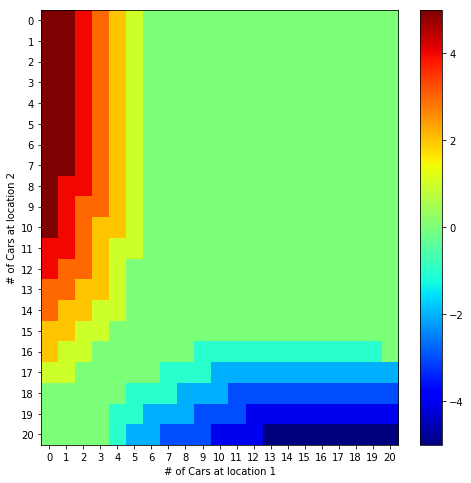

In [14]:
plot_policy(optimal_policy)